In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop
from backprop import gp, srgp, cmgp, crossover, selector, library, project

SAMPLE_SIZE = 200
NOISE = 0.1

POPSIZE = 1000
MAX_STREE_DEPTH = 5
GENERATIONS = 50
GROUP_SIZE = 5  # tournament selector.
MUTATION_RATE = 0.15
ELITISM = 1
BACKPROP_INTV = -1

NBESTS = 4

#logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

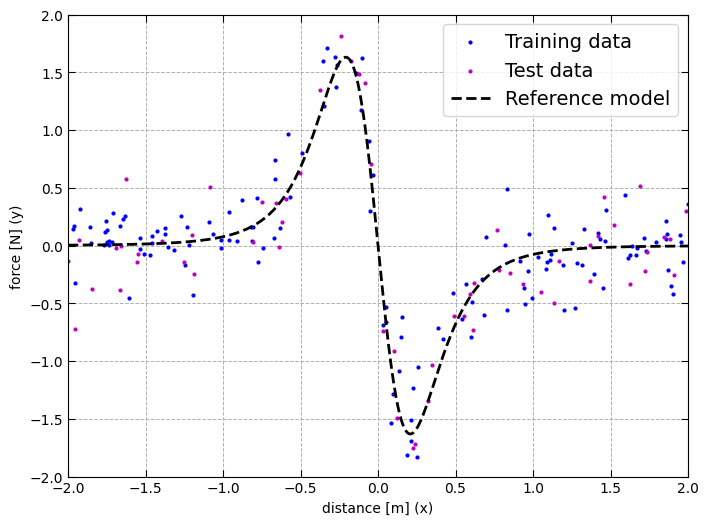

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')
S.split(train_size=0.7)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [ ]:
print(S_train.y.size)
project.project(S_train, S.knowledge)
S_train.get_plotter().plot(width=8, height=6)

In [ ]:
lib = library.Library(2000, 3, S_train)

solutionCreator = gp.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp.MultiMutator(
      gp.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp.FunctionSymbolMutator(),
      gp.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

diversifier = None #gp.SemanticCrowdingDiversifier(S_train)

#evaluator = gp.R2Evaluator(S_train)
#evaluator = gp.FUEvaluator(S_train, S.knowledge)
evaluator = gp.NumericalFUEvaluator(S_train, S.knowledge)

selector = gp.TournamentSelector(GROUP_SIZE)

#crossover2 = gp.SubTreeCrossover(MAX_STREE_DEPTH)
#crossover2 = crossover.ApproxGeometricCrossover(lib, MAX_STREE_DEPTH, diversifier)
crossover2 = crossover.CrossNPushCrossover(lib, MAX_STREE_DEPTH)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover2,
               mutator=multiMutator,
               mutrate=MUTATION_RATE,
               diversifier=diversifier,
               elitism=ELITISM,
               backprop_intv=BACKPROP_INTV,
               knowledge=S.knowledge,
               nbests=NBESTS)

with np.errstate(all='ignore'):
      bests, eval_map = symb_regressor.evolve()
best_stree = bests[0]
best_eval = eval_map[id(best_stree)]

print("--- Best syntax tree ---")
print(best_stree)
print(best_eval)

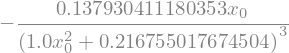

In [5]:
import sympy
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [6]:
print(best_stree.simplify())
print(best_stree.get_max_depth())
print(best_stree.get_nnodes())
#from backprop import lpbackprop
#sat, stree_cost = lpbackprop.lpbackprop(S.knowledge, best_stree, None)
#print(sat)

K_derivs = S.knowledge.get_derivs()
stree_derivs = backprop.SyntaxTree.diff_all(best_stree, K_derivs, include_zeroth=True)
print(sympy.simplify(sympy.factor(stree_derivs[(0,0)].to_sympy())))

print(gp.NumericalFUEvaluator(S_train, S.knowledge).evaluate(best_stree, eval_deriv=True))

(((((0.02 + x0) - (x0 - -0.12)) + -0.03) * (x0 / 0.98)) / cube(((0.19 + square(x0)) + ((x0 + -0.71) - (x0 - 0.74)))))
5
27
-4.13791233541058*x0*(1.0*x0**4 + 0.0867020070698015*x0**2 - 0.0281896426122447)/(1.0*x0**2 + 0.216755017674504)**6
know_mse:  0.0
know_nv:   0
know_n:    80
know_ls:   True
fea_ratio: 1.0
data_r2:   0.9999997821604


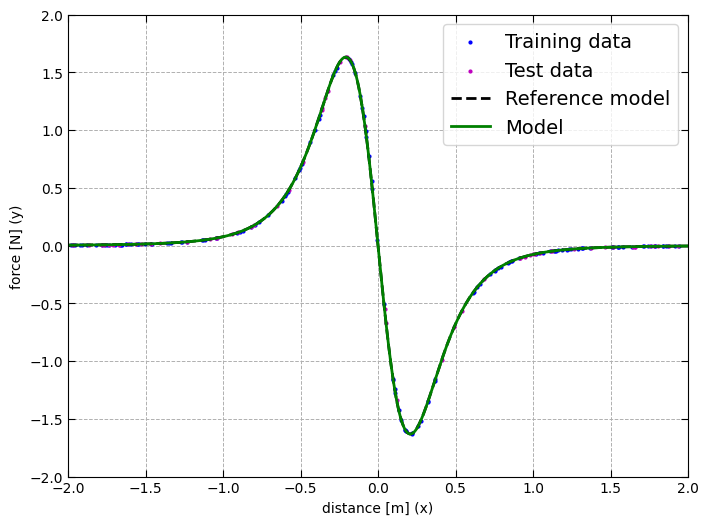

'S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree.diff(0).simplify(), zoomout=3)\nS.knowledge.synthesize(best_stree, S_train.X).get_plotter().plot(width=8, height=6)\n\nK_evaluator = gp.FUEvaluator(S_train, S.knowledge)\nprint(K_evaluator.evaluate(best_stree))\n\nprint(best_stree.diff(0))\nprint(best_stree.diff(0).simplify())'

In [7]:
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
"""S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree.diff(0).simplify(), zoomout=3)
S.knowledge.synthesize(best_stree, S_train.X).get_plotter().plot(width=8, height=6)

K_evaluator = gp.FUEvaluator(S_train, S.knowledge)
print(K_evaluator.evaluate(best_stree))

print(best_stree.diff(0))
print(best_stree.diff(0).simplify())"""

currBest [0.0, 0.21911932623052766, 0.21911932623052766, 0.45715417149198345, 0.8197097997152746, 0.8197097997152746, 0.8957533834677487, 0.9386250734270272, 0.9930803226428377, 0.9930803226428377, 0.9930803226428377, 0.9930803226428377, 0.9930803226428377, 0.9947114392785328, 0.9947114392785328, 0.9988615317558789, 0.998976955999911, 0.9995875147493752, 0.9998488100634456, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999733981877686, 0.9999875918143527, 0.9999875918143527, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999995880977369, 0.9999997821604, 0.9999997821604, 0.9999997821604]
currAvg [2.2

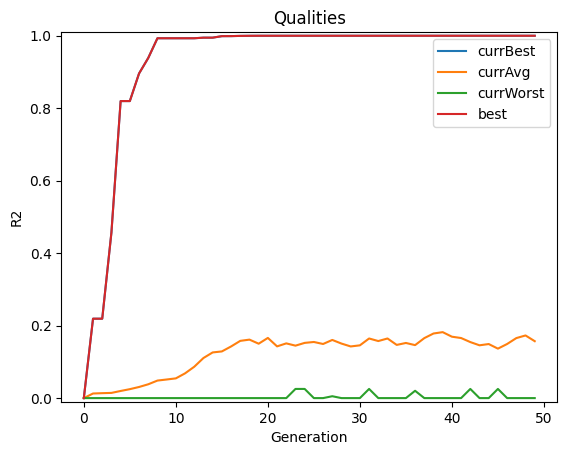

In [8]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)
    print(quality, qseries)
plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

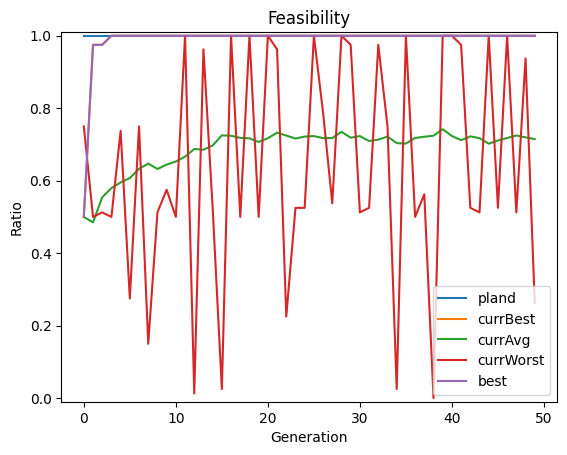

In [9]:
plt.plot(symb_regressor.stats.pland, label='pland')

for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

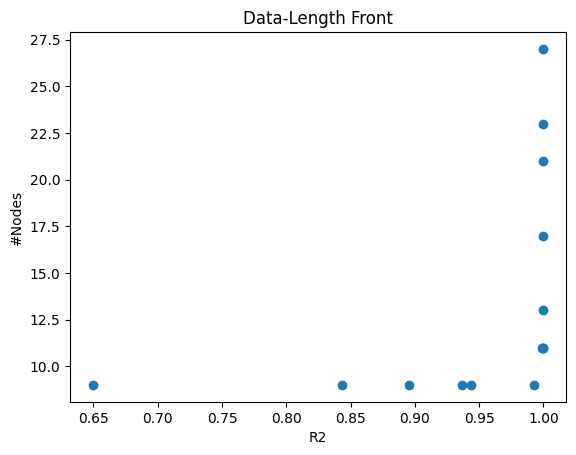

,Score,Model,fpn,R2,Length
0,0,((-0.14 * x0) / cube((0.21 + square(x0)))),0.110305,0.992742,9
1,1,((-0.18 * x0) / cube((square(x0) + 0.27))),0.104832,0.943489,9
2,2,((x0 * -0.14) / cube((square(x0) + 0.24))),0.104082,0.936735,9
3,3,((-0.13 * x0) / cube((0.19 + square(x0)))),0.099489,0.895398,9
4,4,((x0 * -0.14) / cube((0.19 + square(x0)))),0.093733,0.843594,9
5,5,((x0 * -0.14) / cube((0.37 + (-0.15 + square(x...,0.090903,0.999937,11
6,6,((x0 * -0.14) / cube((0.19 + (square(x0) - -0....,0.090840,0.999240,11
7,7,((-0.12 * x0) / cube((0.37 + (-0.17 + square(x...,0.090806,0.998862,11
8,8,(((x0 * 1.00) * -0.14) / cube((0.37 + (-0.15 +...,0.076922,0.999988,13
9,9,((-0.27 * x0) / cube((square(x0) + 0.41))),0.072158,0.649419,9


In [10]:
front = symb_regressor.fea_front_tracker.get_front()

x = [data for _, data, _ in front]
y = [length for _, _, length in front]

plt.scatter(x, y)
plt.xlabel('R2')
plt.ylabel('#Nodes')
plt.title('Data-Length Front')
plt.show()

pd_data = []
for idx, (stree, data, length) in enumerate(front):
    pd_data.append([idx, stree, data/length, data, length])

import pandas as pd
pd.DataFrame(pd_data, columns=['Score', 'Model', 'fpn', 'R2', 'Length'])